In [1]:
import numpy as np
__DEBUG_MODE__ = False

In [2]:
nLIGHT = 255
nDARK = 125
nOBJECT = 0

In [3]:
def light_side_of(M0, direction, nLIGHT, nOBJECT):
    M = np.copy(M0) # hard copy the input 2-D matrix, M0
    if direction == "left":
        lsource = np.full(M.shape[0], True) # set light source
        for n in range(M.shape[1]): # sweep light source from left to right
            ii = M[:,n] == nOBJECT
            lsource[ii] = False   # when meet objects, turn off light source
            M[lsource,n] = nLIGHT
    elif direction == "right":
        lsource = np.full(M.shape[0], True) # set light source
        for n in reversed(range(M.shape[1])): # sweep light source from right to left
            ii = M[:,n] == nOBJECT
            lsource[ii] = False  # when meet objects, turn off light source
            M[lsource,n] = nLIGHT
    elif direction == "bottom":
        lsource = np.full(M.shape[1], True) # set light source
        for n in range(M.shape[0]): # sweep light source from bottom to top
            ii = M[n,:] == nOBJECT
            lsource[ii] = False  # when meet objects, turn off light source
            M[n,lsource] = nLIGHT
    elif direction == "top":
        lsource = np.full(M.shape[1], True) # set light source
        for n in reversed(range(M.shape[0])): # sweep light source from top to bottom
            ii = M[n,:] == nOBJECT
            lsource[ii] = False  # when meet objects, turn off light source
            M[n,lsource] = nLIGHT
    return M
def data2matrix(data, data_lower_bound, data_upper_bound, data_resolution = 100):
    assert(len(data.shape) == 1) # assert that data be rank 0
    Nx = data.shape[0] # the number of data points
    Ny = data_resolution # the number of y-axis resolution
    nx = np.arange(0, Nx) # column indices for matrix M
    ny = ((data - data_lower_bound) / (data_upper_bound - data_lower_bound) * (Ny-1)).astype(int) # row indices for matrix M
    #---------------------------------------------------------------
    M = np.full((Ny, Nx), nDARK, dtype=np.uint8)
    M[ny,nx] = nOBJECT  # draw data points on the matrix
    #---------------------------------------------------------------
    MM = np.full((Ny, 2*Nx-1), nDARK, dtype=np.uint8) # expanded version of matrix
    MM[ny, np.arange(0,2*Nx-1,2)] = M[ny,nx]
    MM[ny[0:-1], np.arange(1,2*Nx-1,2)] = M[ny[0:-1],nx[0:-1]]
    MM[ny[1:], np.arange(1,2*Nx-1,2)] = M[ny[1:],nx[1:]]
    #---------------------------------------------------------------
    MM = light_side_of(MM, "top", nLIGHT, nOBJECT)
    MM = light_side_of(MM, "bottom", nLIGHT, nOBJECT)
    #---------------------------------------------------------------
    M[M == nDARK] = nLIGHT
    MM[MM == nDARK] = nOBJECT
    #---------------------------------------------------------------
    ddata = np.full(2*Nx-1, np.nan)
    ddata[np.arange(0,2*Nx-1,2)] = data[:]
    ddata[np.arange(1,2*Nx-1,2)] = (data[0:-1] + data[1:]) / 2.0
    #---------------------------------------------------------------
    data_scale = np.linspace(data_lower_bound, data_upper_bound, Ny, endpoint=True)
    return M, MM, ddata, data_scale
def find_valley_in_matrix(MM, ddata, data_scale, threshold, pourWaterAt = "top"):
    MM_lake = light_side_of(MM, pourWaterAt, nDARK, nOBJECT)  # fill with water
    MM_lake = light_side_of(MM_lake, "left", nLIGHT, nOBJECT) # spill over-flow to the left
    MM_lake = light_side_of(MM_lake, "right", nLIGHT, nOBJECT) # spill over-flow to the right
    #---------------------------------------------------------------
    TT = np.zeros(MM_lake.shape)
    TT[MM_lake == nDARK] = 1
    tt = np.sum(TT, axis = 0)
    #---------------------------------------------------------------
    d_scale = data_scale[1] - data_scale[0]
    percent_change = 100 * np.abs(d_scale * tt / ddata)
    #---------------------------------------------------------------
    ivalley = (percent_change == np.amax(percent_change)) & (percent_change > threshold)
    return ivalley, MM_lake
def find_valley_in_data(data, data_lower_bound, data_upper_bound, threshold, pourWaterAt = "top", data_resolution = 100):
    M, MM, ddata, data_scale = data2matrix(data, data_lower_bound, data_upper_bound, data_resolution)
    ivalley, MM_lake = find_valley_in_matrix(MM, ddata, data_scale, threshold, pourWaterAt)
    ilow = ivalley[np.arange(0,MM_lake.shape[1],2)]
    return ilow, M, MM, MM_lake
def find_valleys_in_data(data, data_lower_bound, data_upper_bound, threshold, pourWaterAt = "top", data_resolution = 100):
    N = data.shape[0]
    ilows = np.full(N, False)
    ilows[0] = True
    ilows[-1] = True
    nline = np.arange(0,N)
    icheck = np.full(N, True) # need-to-check area
    ifocus = np.full(N, True) # focus-to-check area
    for i in range(N):
        #print(i)
        ilow, M, MM, MM_lake = find_valley_in_data(data[ifocus], data_lower_bound, data_upper_bound, threshold, pourWaterAt, data_resolution)
        if any(ilow):
            ilows[ifocus] = ilows[ifocus] | ilow  # update lows
        else:
            icheck[nline[ifocus][0:-1]] = False
            #print(">> {} % completed...".format(100*(np.sum(~icheck)/len(icheck))))
        nums = nline[icheck & ilows]
        if len(nums) < 2:    # if there is no two points
            break
        ifocus = np.full(data.shape[0], False)
        ifocus[nums[0]:(nums[1]+1)] = True
    ilows[0] = False
    ilows[-1] = False
    return ilows, M, MM, MM_lake
def matrix2image(M):
    img = np.zeros((M.shape[0], M.shape[1], 3), dtype=np.uint8)
    img[:] = M.reshape(M.shape[0], M.shape[1], 1)
    return img

In [4]:
def model(data, percent_threshold, data_resolution = 100):
    print("> Lows/Highs Detecter Algorithm started...")
    print(">> version = 2018-01-03")
    data_lower_bound = np.amin(data)
    data_upper_bound = np.amax(data)
    ilows, M1, MM1, MM_lake1 = find_valleys_in_data(data, data_lower_bound, data_upper_bound, percent_threshold, "top", data_resolution)
    percent_threshold2 = 100.0 * percent_threshold / (100.0 + percent_threshold) 
    ihighs, M2, MM2, MM_lake2 = find_valleys_in_data(data, data_lower_bound, data_upper_bound, percent_threshold2, "bottom", data_resolution)
    #plt.imshow(matrix2image(MM1))
    #plt.show()
    return ilows, ihighs
def find_nears(data, ilows, ihighs, percent_data_error = 0.5):
    assert(len(data.shape) == 1)
    iboth = ilows | ihighs
    nnn = np.arange(1, len(iboth)+1)
    nnl = np.insert(nnn[iboth], 0, 0) # insert zero to the beginning of the array
    nnr = np.append(nnn[iboth], len(iboth)+1) # insert zero to the end of the array
    rgl = np.diff(nnl) - 1 # number of left elements 
    rgr = np.diff(nnr) - 1 # number of right elements 
    #------------------------------------------------
    nbothl = np.zeros(iboth.shape, dtype=np.int64) # number of left elements
    nbothl[iboth] = -rgl
    nbothr = np.zeros(iboth.shape, dtype=np.int64) # number of right elements 
    nbothr[iboth] = +rgr
    #------------------------------------------------
    inearlows = np.copy(ilows) # near-lowest points
    inearhighs = np.copy(ihighs) # near-highest points
    for i in range(np.amin(nbothl), np.amax(nbothr)+1):
        if i > 0: # sweep for right elements
            n0 = np.arange(0, len(data)-i)
            n1 = np.arange(i, len(data))
        elif i < 0: # sweep for left elements
            n0 = np.arange(-i, len(data))
            n1 = np.arange(0, len(data)+i)
        if i != 0:
            ill = ilows[n0] & (nbothl[n0] <= i) & (i <= nbothr[n0]) & (abs((data[n1] - data[n0]) / data[n0]) <= (percent_data_error / 100.0))
            inearlows[n1] = inearlows[n1] | ill # update
            ihh = ihighs[n0] & (nbothl[n0] <= i) & (i <= nbothr[n0]) & (abs((data[n0] - data[n1]) / data[n1]) <= (percent_data_error / 100.0))
            inearhighs[n1] = inearhighs[n1] | ihh # update
    return inearlows, inearhighs

> Lows/Highs Detecter Algorithm started...
>> version = 2018-01-03
1.0330657958984375 sec


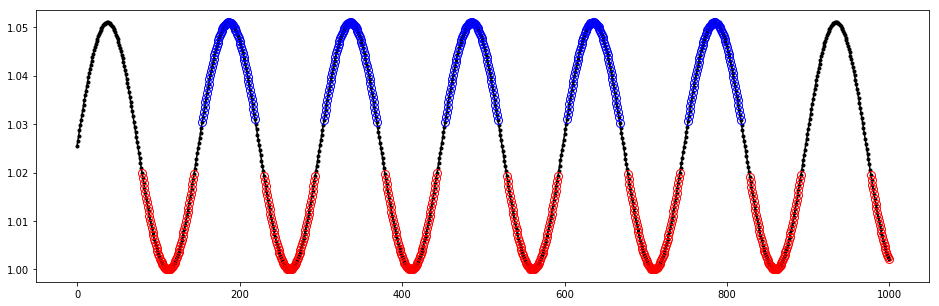

In [5]:
if __DEBUG_MODE__:
    import matplotlib.pyplot as plt
    import time
    %matplotlib inline

    #np.random.seed(1)
    #data = np.random.rand(500) + 3 # example: random noise
    data = 1.0 + (5.1/100/2)*(1 + np.sin(np.linspace(0,42,1000))) # example: sine wave
    #---------------------------------------------------------------
    tic = time.time()
    ilows, ihighs = model(data, percent_threshold = 5, data_resolution = 100)   # threshold [%]
    inearlows, inearhighs = find_nears(data, ilows, ihighs, percent_data_error = 2) # error [%]
    toc = time.time()
    print(str(toc-tic) + " sec")
    #---------------------------------------------------------------
    plt.figure(figsize=(16,5))
    plt.plot(data,'k.-')
    plt.plot(np.arange(0,data.shape[0])[ilows], data[ilows],'ro', markersize=4)
    plt.plot(np.arange(0,data.shape[0])[ihighs], data[ihighs],'bo', markersize=4)
    plt.plot(np.arange(0,data.shape[0])[inearlows], data[inearlows],'ro', markersize=8, markerfacecolor='none')
    plt.plot(np.arange(0,data.shape[0])[inearhighs], data[inearhighs],'bo', markersize=8, markerfacecolor='none')
    #plt.xlim(800, 850)
    plt.show()